In [1]:
import sys
sys.path.append('/Users/yuch8913/miniforge3/envs/er3t_env/lib/python3.8/site-packages')
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib
from glob import glob
import numpy as np
from sys import exit as ext
import copy
from bisect import bisect_left
from oco_post_class_ywc import *
from matplotlib import cm
from scipy.interpolate import interpn
from scipy import stats
import geopy.distance
import xarray as xr
import seaborn as sns
from tool_code import *
%matplotlib inline
import os, pickle 
#"""

from matplotlib import font_manager

font_path = '/System/Library/Fonts/Supplemental/Arial.ttf'  # Your font path goes here
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
#"""

import warnings
warnings.filterwarnings("ignore")

In [2]:
oco_l1b_file = '../simulation/data/oco/oco2_L1bScND_22850a_181018_B10003r_200409205805.h5'
l1b = h5py.File(oco_l1b_file, 'r')
oco_l2_file = '../simulation/data/oco/oco2_L2StdND_22850a_181018_B10004r_200520201845.h5'
l2 = h5py.File(oco_l2_file, 'r')
oco_met_file = '../simulation/data/oco/oco2_L2MetND_22850a_181018_B10003r_200409205805.h5'
met = h5py.File(oco_met_file, 'r')

In [3]:
met.keys()

<KeysViewHDF5 ['Aerosol', 'Dimensions', 'FootprintGeometry', 'FootprintMeteorology', 'Metadata', 'Meteorology', 'MeteorologyDiagnostics', 'Shapes', 'SoundingGeometry']>

In [4]:
l1b['SoundingMeasurements'].keys()

<KeysViewHDF5 ['rad_continuum_o2', 'rad_continuum_strong_co2', 'rad_continuum_weak_co2', 'radiance_o2', 'radiance_strong_co2', 'radiance_weak_co2', 'snr_o2_l1b', 'snr_strong_co2_l1b', 'snr_weak_co2_l1b']>

In [5]:
l1b['InstrumentHeader'].keys()

<KeysViewHDF5 ['bad_sample_list', 'dispersion_coef_samp', 'granule_degradation_factor', 'ils_delta_lambda', 'ils_relative_response', 'measureable_signal_max_observed', 'snr_coef']>

In [6]:
l1b['FootprintGeometry'].keys()


<KeysViewHDF5 ['footprint_altitude', 'footprint_altitude_uncert', 'footprint_aspect', 'footprint_azimuth', 'footprint_land_fraction', 'footprint_latitude', 'footprint_latitude_geoid', 'footprint_longitude', 'footprint_longitude_geoid', 'footprint_los_surface_bidirectional_angle', 'footprint_o2_qual_flag', 'footprint_plane_fit_quality', 'footprint_polarization_angle', 'footprint_slope', 'footprint_solar_azimuth', 'footprint_solar_surface_bidirectional_angle', 'footprint_solar_zenith', 'footprint_stokes_coefficients', 'footprint_strong_co2_qual_flag', 'footprint_surface_roughness', 'footprint_time_string', 'footprint_time_tai93', 'footprint_vertex_altitude', 'footprint_vertex_latitude', 'footprint_vertex_longitude', 'footprint_weak_co2_qual_flag', 'footprint_zenith']>

In [7]:
l1b['FrameConfiguration'].keys()

<KeysViewHDF5 ['color_slice_position_o2', 'color_slice_position_strong_co2', 'color_slice_position_weak_co2', 'footprint_spatial_end_position', 'footprint_spatial_start_position', 'initial_unused_pixels']>

In [8]:
l1b['FrameGeometry'].keys()

<KeysViewHDF5 ['ground_track', 'pitch', 'relative_velocity', 'roll', 'spacecraft_alt', 'spacecraft_lat', 'spacecraft_lon', 'spacecraft_position', 'spacecraft_velocity', 'yaw']>

In [9]:
l1b['SliceMeasurements'].keys()

<KeysViewHDF5 ['radiance_slice_o2', 'radiance_slice_strong_co2', 'radiance_slice_weak_co2']>

In [10]:
l1b['SoundingGeometry'].keys()

<KeysViewHDF5 ['sounding_altitude', 'sounding_altitude_uncert', 'sounding_aspect', 'sounding_azimuth', 'sounding_center_offset_o2_weak_co2', 'sounding_center_offset_strong_co2_o2', 'sounding_center_offset_weak_co2_strong_co2', 'sounding_id', 'sounding_land_fraction', 'sounding_land_water_indicator', 'sounding_latitude', 'sounding_latitude_geoid', 'sounding_longitude', 'sounding_longitude_geoid', 'sounding_los_surface_bidirectional_angle', 'sounding_operation_mode', 'sounding_overlap', 'sounding_overlap_o2_weak_co2', 'sounding_overlap_strong_co2_o2', 'sounding_overlap_weak_co2_strong_co2', 'sounding_plane_fit_quality', 'sounding_polarization_angle', 'sounding_qual_flag', 'sounding_relative_velocity', 'sounding_slant_path_diff_o2_weak_co2', 'sounding_slant_path_diff_strong_co2_o2', 'sounding_slant_path_diff_weak_co2_strong_co2', 'sounding_slope', 'sounding_solar_azimuth', 'sounding_solar_distance', 'sounding_solar_relative_velocity', 'sounding_solar_surface_bidirectional_angle', 'soundin

In [40]:
iband = 0
s  = 0    # pre-set footprint (0-7)
n  = 1016 # pre-set number of wavelengths per channel (1...1016 consistent with L1b file)

c  = np.arange(n)+1.   # wavelength #
wl = np.zeros((8, n))       # holds wavelengths

# Oxygen A-Band 
# coefficients (for all 8 spectrometers/footprints)
o2 =  [[0.75764920,   1.7491747e-05,  -2.7358146e-09,  -7.5115978e-14,   1.3216626e-16,  -7.2746905e-20],
       [0.75764505,   1.7487877e-05,  -2.7162856e-09,  -1.1507003e-13,   1.6866096e-16,  -8.4978715e-20],
       [0.75763985,   1.7501410e-05,  -2.7857486e-09,   3.3728184e-14,   2.6453049e-17,  -3.5096109e-20],
       [0.75763497,   1.7512335e-05,  -2.8476549e-09,   1.6673748e-13,  -9.8525790e-17,   7.8748270e-21],
       [0.75763166,   1.7498652e-05,  -2.7832800e-09,   2.7980819e-14,   3.5244353e-17,  -3.9636529e-20],
       [0.75762795,   1.7491036e-05,  -2.7515283e-09,  -3.6039510e-14,   9.2785422e-17,  -5.8634519e-20],
       [0.75762404,   1.7487508e-05,  -2.7449279e-09,  -3.7754169e-14,   8.0435948e-17,  -4.8428847e-20],
       [0.75761970,   1.7488254e-05,  -2.7426712e-09,  -6.1350910e-14,   1.2113713e-16,  -6.9542687e-20]]
# Weak CO2
# coefficients (for all 8 spectrometers/footprints)
co2w = [[1.5905422,   3.6443391e-05,  -5.9516755e-09,   9.3932921e-13,  -9.4723993e-16,   3.1630847e-19],
        [1.5905460,   3.6435451e-05,  -5.9323636e-09,   9.2258273e-13,  -9.4880149e-16,   3.2197292e-19],
        [1.5905493,   3.6437757e-05,  -5.9672571e-09,   1.0182617e-12,  -1.0508895e-15,   3.6013836e-19],
        [1.5905525,   3.6434047e-05,  -5.9611448e-09,   1.0179609e-12,  -1.0580387e-15,   3.6409084e-19],
        [1.5905548,   3.6435218e-05,  -5.9640508e-09,   1.0172446e-12,  -1.0510189e-15,   3.5946234e-19],
        [1.5905561,   3.6446241e-05,  -6.0181002e-09,   1.1379735e-12,  -1.1728438e-15,   4.0444608e-19],
        [1.5905582,   3.6443203e-05,  -6.0011675e-09,   1.1013092e-12,  -1.1390699e-15,   3.9424472e-19],
        [1.5905584,   3.6456777e-05,  -6.0479051e-09,   1.1766416e-12,  -1.1901061e-15,   4.0387881e-19]]
# Strong CO2
# coefficients (for all 8 spectrometers/footprints)
co2s = [[2.0430079,   4.6924257e-05,  -7.5338425e-09,   9.0800411e-14,   3.8512060e-16,  -1.9286362e-19],
        [2.0430259,   4.6925154e-05,  -7.5420031e-09,   1.1306612e-13,   3.5534676e-16,  -1.8192273e-19],
        [2.0430429,   4.6943726e-05,  -7.6450707e-09,   3.4315164e-13,   1.2787660e-16,  -9.9907394e-20],
        [2.0430596,   4.6953049e-05,  -7.6953095e-09,   4.5770955e-13,   1.1048747e-17,  -5.5478761e-20],
        [2.0430753,   4.6963590e-05,  -7.7202543e-09,   4.7985190e-13,   8.9334853e-18,  -5.9475311e-20],
        [2.0430897,   4.6992327e-05,  -7.8585304e-09,   7.8214971e-13,  -2.8506338e-16,   4.5177323e-20],
        [2.0431050,   4.6995609e-05,  -7.8523220e-09,   7.5326395e-13,  -2.4115874e-16,   2.3453380e-20],
        [2.0431196,   4.7010776e-05,  -7.9255174e-09,   9.3750936e-13,  -4.4263515e-16,   1.0324130e-19]]

if iband < 0 or iband > 2:
    sys.exit('oco_wl: wrong band #')
if iband == 0 :
    a = np.array(o2)[s, :]
if iband == 1:
    a = np.array(co2w)[s, :]
if iband == 2:
    a = np.array(co2s)[s, :]

for footprint in range(8):
    for l in range(6):
        wl[footprint] = wl[footprint]+a[l]*c**l

In [41]:
wl.shape

(8, 1016)

In [22]:
1e4/wl

array([13198.41580082, 13198.11124778, 13197.80680412, ...,
       12944.04039884, 12943.84142919, 12943.64256311])

In [24]:
o2a_rad = l1b['SoundingMeasurements']['radiance_o2'][...]
o2a_rad.shape

(8334, 8, 1016)

In [25]:
o2a_qf = l1b['FootprintGeometry']['footprint_o2_qual_flag'][...]
o2a_qf.shape

(8334, 8)

In [27]:
c = 299792458.0
h = 6.62607015e-34
E = h*c/(wl*1e-6)

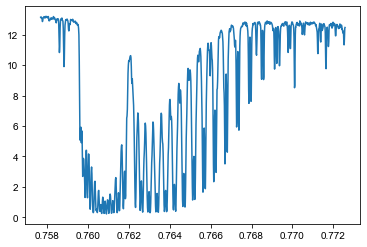

In [28]:
plt.plot(wl, o2a_rad[0,0,:]*E)

In [29]:
o2a_con = l1b['SoundingMeasurements']['rad_continuum_o2'][...]
o2a_con.shape

(8334, 8)

In [33]:
o2a_con_r = o2a_con.repeat(1016).reshape((o2a_con.shape[0], o2a_con.shape[1], 1016))
o2a_con_r[0,0,:]

array([4.970801e+19, 4.970801e+19, 4.970801e+19, ..., 4.970801e+19,
       4.970801e+19, 4.970801e+19], dtype=float32)

In [394]:
sfc_p = met["Meteorology"]["surface_pressure_met"][...]
sfc_T = met["Meteorology"]["skin_temperature_met"][...]

In [38]:
T = o2a_rad/o2a_con_r
A = -np.log10(T)
tau = -np.log(T)

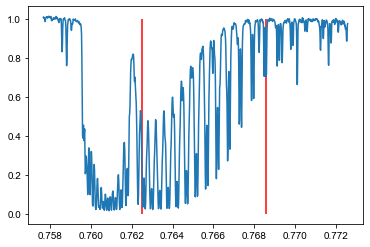

In [70]:
plt.plot(wl[0], T[0,0,:])
plt.vlines(wl[0, [290, 700]], 0, 1, 'r')
plt.show()

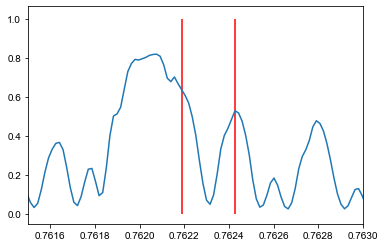

In [95]:
plt.plot(wl[0], T[0,0,:])
plt.vlines(wl[0, [270, 285]], 0, 1, 'r')
plt.xlim(0.7615, 0.763)
plt.show()

0.07821578392097628 nm


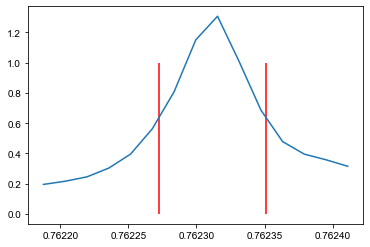

In [104]:


start, end = 270, 285
plt.plot(wl[0, start:end], A[0,0,start:end])
max_ind = np.argmax((A[0,0,start:end]))
hm = A[0,0,max_ind+start]/2

from scipy import interpolate

f = interpolate.interp1d(wl[0, start:end], A[0,0,start:end])
xx = np.linspace(wl[0, start], wl[0, end-1], 101)
yy = f(xx)


hm_ind = np.argsort(np.abs(yy-hm))[:2]
plt.vlines(xx[hm_ind], 0, 1, 'r')
FWHM = np.abs(xx[hm_ind[0]]-xx[hm_ind[1]])
#plt.xlim(0.762, 0.765)
print(FWHM*1e3, 'nm')

In [105]:
A.shape

(8334, 8, 1016)

In [ ]:
from scipy import interpolate

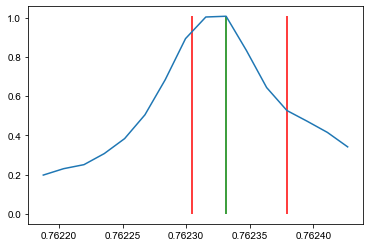

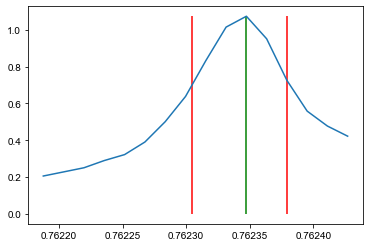

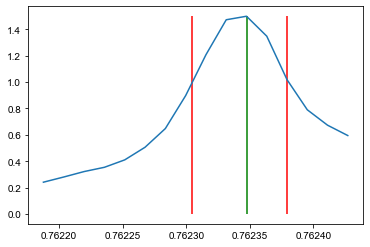

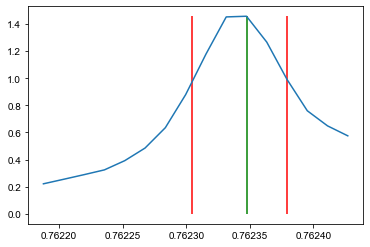

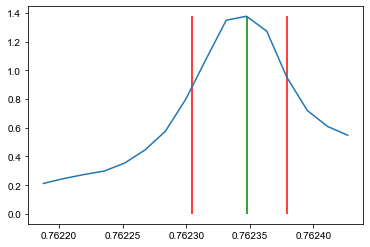

In [395]:
FWHM_array = np.zeros((A.shape[0], A.shape[1]))

start, end = 270, 285+1

for i in range(A.shape[0]):
    for fp in range(8):
        try:
            max_ind = np.argmax((A[i,fp,start:end]))
            hm = A[i,fp,max_ind+start]/2



            f_l = interpolate.interp1d(wl[fp, start:start+max_ind], A[i,fp,start:start+max_ind], fill_value="extrapolate")
            xx_l = np.linspace(wl[fp, start], wl[fp, start+max_ind-1], 101)
            yy_l = f_l(xx_l)
            hm_ind_l = np.argmin(np.abs(yy_l-hm))

            f_r = interpolate.interp1d(wl[fp, start+max_ind:end], A[i,fp,start+max_ind:end], fill_value="extrapolate")
            xx_r = np.linspace(wl[fp, start+max_ind], wl[fp, end-1], 101)
            yy_r = f_r(xx_r)
            hm_ind_r = np.argmin(np.abs(yy_r-hm))


            FWHM = np.abs(xx[hm_ind_r]-xx[hm_ind_l])*1e3 # to nm
            FWHM_array[i,fp] = FWHM

            if FWHM < 0.003:
                plt.clf()
                plt.vlines(wl[fp, start+max_ind], 0, A[i,fp,max_ind+start],'green')
                plt.plot(wl[fp, start:end], A[i,fp,start:end])
                plt.vlines(xx[hm_ind], 0, hm*2, 'r')
                plt.show()
        except:
            FWHM_array[i,fp] = np.nan
        #print(f'{FWHM:.3f}', 'nm')

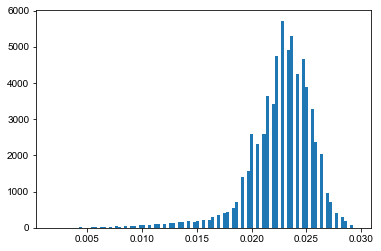

In [158]:
plt.hist(FWHM_array.flatten(), bins=101)
plt.show()

In [115]:
snd_id = l1b['SoundingGeometry']['sounding_id'][...]
snd_lon = l1b['SoundingGeometry']['sounding_id'][...]
snd_id.shape

(8334, 8)

In [258]:
png       = ['../simulation/data/20181018_central_asia_2_470cloud_test2_20181018/aqua_rgb_2018-10-18_55.00-55.60-33.70-34.45.png',
             [55.00, 55.60, 33.70, 34.45]]
img = png[0]
wesn= png[1]

In [170]:
png       = ['../simulation/data/20181018_1_20181018/aqua_rgb_2018-10-18_55.40-55.95-32.30-33.20.png',
             [55.40, 55.95, 32.30, 33.2]]
img = png[0]
wesn= png[1]

In [327]:
png       = ['../simulation/data/20181018_central_asia_2_470cloud_test0320_20181018/aqua_rgb_2018-10-18_51.85-58.15-27.85-37.15.png',
             [51.85,58.15,27.85,37.15]]
img = png[0]
wesn= png[1]

In [113]:
litefile = '../dat/oco2_LtCO2_181018_B10206Ar_200730042453s.nc4'
lite = xr.open_dataset(litefile)
lite_snd = xr.open_dataset(litefile, group='Sounding')

In [293]:
xco2 = l2["RetrievalResults"]['xco2']

In [321]:
lon_w, lon_e = wesn[0], wesn[1]
lat_s, lat_n = wesn[2], wesn[3]
lon_range = np.logical_and(lite.longitude >= lon_w, lite.longitude <= lon_e)
lat_range = np.logical_and(lite.latitude >= lat_s, lite.latitude <= lat_n)

select = np.where(np.logical_and(lon_range, lat_range))
lite_snd_list = np.array(lite.sounding_id[select], dtype=np.int)

In [322]:
xco2_array = np.zeros((A.shape[0], A.shape[1]))
qf_array = np.zeros((A.shape[0], A.shape[1], 3))
alt_array = np.zeros((A.shape[0], A.shape[1]), dtype=float)
qf_lon, qf_lat = np.zeros((A.shape[0], A.shape[1])), np.zeros((A.shape[0], A.shape[1]))
# qf, qf_bitflag, qf_simpleflag\
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        snd = snd_id[i, j]
        #print('-'*15)
        #print(snd)
        if snd in lite_snd_list:
            index = np.where(lite_snd_list == snd)[0][0]

            xco2_quality_flag = np.float(lite.xco2_quality_flag[select][index])
            xco2_qf_bitflag = np.float(lite.xco2_qf_bitflag[select][index])
            xco2_qf_simple_bitflag = np.float(lite.xco2_qf_simple_bitflag[select][index])
            xco2_array[i, j] = np.float(lite.xco2[select][index])
            qf_array[i, j, :] = (xco2_quality_flag, xco2_qf_bitflag, xco2_qf_simple_bitflag)
            qf_lat[i, j] = np.float(lite.latitude[select][index])
            qf_lon[i, j] = np.float(lite.longitude[select][index])
            alt_array[i, j] = np.float(lite_snd.altitude[select][index])
        else:
            xco2_array[i, j] = np.nan
            qf_array[i, j, :] = (np.nan,)*3
            qf_lat[i, j] = np.nan
            qf_lon[i, j] = np.nan
            alt_array[i, j] = np.nan


In [323]:
(qf_array[:,:,0]==0).sum()

1571

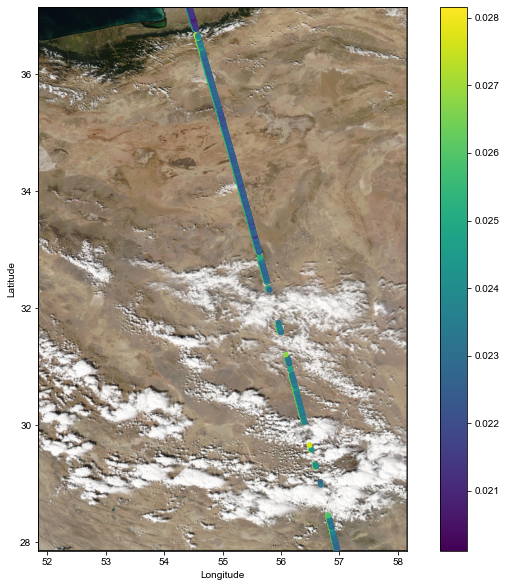

In [396]:
f,frame=plt.subplots(figsize=(12, 10))
img = png[0]
wesn= png[1]
img = mpimg.imread(img)
frame.imshow(img,extent=wesn)
lon_dom = [lon_w, lon_e]
lat_dom = [lat_s, lat_n]
frame.set_xlim(np.min(lon_dom), np.max(lon_dom))
frame.set_ylim(np.min(lat_dom), np.max(lat_dom))
qf_01 = np.logical_or(qf_array[:, :, 0].flatten()==0, qf_array[:, :, 0].flatten()==1)
c = frame.scatter(qf_lon.flatten()[qf_01], qf_lat.flatten()[qf_01], s=20,
              marker='o', c=FWHM_array.flatten()[qf_01])

f.colorbar(c)
#frame.scatter(lon_cld[cld_list>0], lat_cld[cld_list>0], s=5, color='r')
#for i in range(len(boundary_list)):
#    boundary = boundary_list[i]
#    plot_rec(np.mean(boundary[0][:2]), np.mean(boundary[0][2:]), 
#             0.5, lat_interval, 
#             frame, 'r')
#plt.legend(fontsize=16, facecolor='white')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

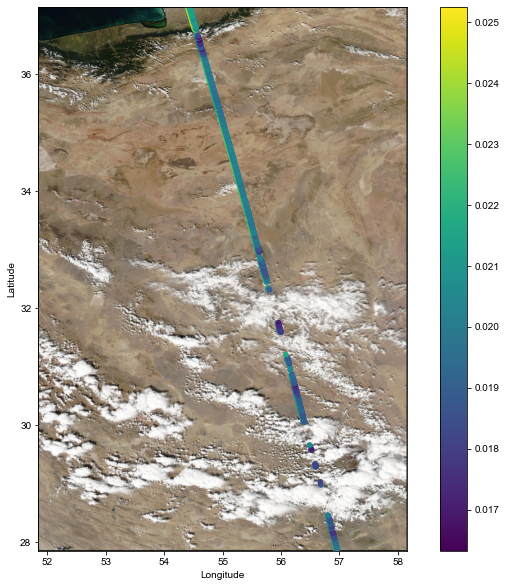

In [398]:
f,frame=plt.subplots(figsize=(12, 10))
img = png[0]
wesn= png[1]
img = mpimg.imread(img)
frame.imshow(img,extent=wesn)
lon_dom = [lon_w, lon_e]
lat_dom = [lat_s, lat_n]
frame.set_xlim(np.min(lon_dom), np.max(lon_dom))
frame.set_ylim(np.min(lat_dom), np.max(lat_dom))
qf_01 = np.logical_or(qf_array[:, :, 0].flatten()==0, qf_array[:, :, 0].flatten()==1)
c = frame.scatter(qf_lon.flatten()[qf_01], qf_lat.flatten()[qf_01], s=20,
              marker='o', c=(FWHM_array*sfc_p/101325*(296/sfc_T)).flatten()[qf_01])

f.colorbar(c)
#frame.scatter(lon_cld[cld_list>0], lat_cld[cld_list>0], s=5, color='r')
#for i in range(len(boundary_list)):
#    boundary = boundary_list[i]
#    plot_rec(np.mean(boundary[0][:2]), np.mean(boundary[0][2:]), 
#             0.5, lat_interval, 
#             frame, 'r')
#plt.legend(fontsize=16, facecolor='white')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

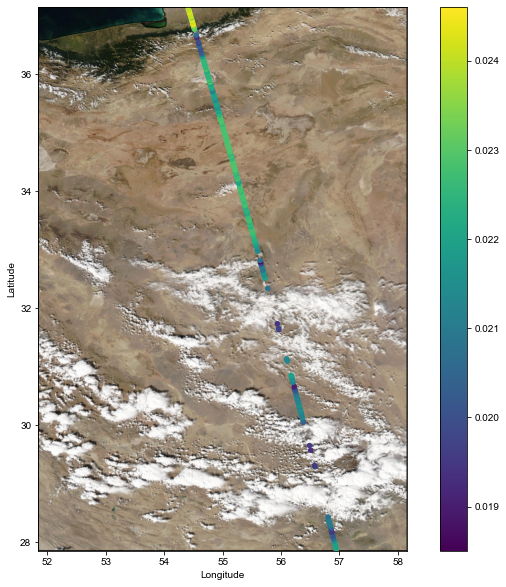

In [399]:
f,frame=plt.subplots(figsize=(12, 10))
img = png[0]
wesn= png[1]
img = mpimg.imread(img)
frame.imshow(img,extent=wesn)
lon_dom = [lon_w, lon_e]
lat_dom = [lat_s, lat_n]
frame.set_xlim(np.min(lon_dom), np.max(lon_dom))
frame.set_ylim(np.min(lat_dom), np.max(lat_dom))
qf_01 = np.logical_or(qf_array[:, 0, 0].flatten()==0, qf_array[:, 0, 0].flatten()==1)
c = frame.scatter(qf_lon[:, 0].flatten()[qf_01], qf_lat[:, 0].flatten()[qf_01], s=20,
              marker='o', c=(FWHM_array*sfc_p/101325*(296/sfc_T))[:, 0].flatten()[qf_01])

f.colorbar(c)
#frame.scatter(lon_cld[cld_list>0], lat_cld[cld_list>0], s=5, color='r')
#for i in range(len(boundary_list)):
#    boundary = boundary_list[i]
#    plot_rec(np.mean(boundary[0][:2]), np.mean(boundary[0][2:]), 
#             0.5, lat_interval, 
#             frame, 'r')
#plt.legend(fontsize=16, facecolor='white')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

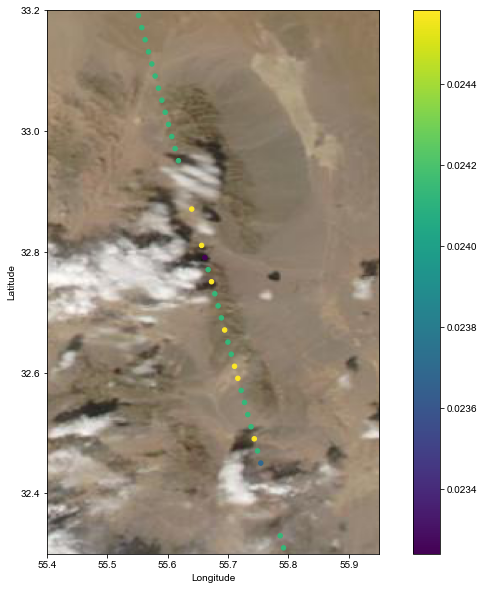

In [177]:
f,frame=plt.subplots(figsize=(12, 10))
img = png[0]
wesn= png[1]
img = mpimg.imread(img)
frame.imshow(img,extent=wesn)
lon_dom = [lon_w, lon_e]
lat_dom = [lat_s, lat_n]
frame.set_xlim(np.min(lon_dom), np.max(lon_dom))
frame.set_ylim(np.min(lat_dom), np.max(lat_dom))
fp = 3
qf_01 = np.logical_or(qf_array[:, fp, 0].flatten()==0, qf_array[:, fp, 0].flatten()==1)
c = frame.scatter(qf_lon[:, fp].flatten()[qf_01], qf_lat[:, fp].flatten()[qf_01], s=20,
              marker='o', c=FWHM_array[:, fp].flatten()[qf_01])

f.colorbar(c)
#frame.scatter(lon_cld[cld_list>0], lat_cld[cld_list>0], s=5, color='r')
#for i in range(len(boundary_list)):
#    boundary = boundary_list[i]
#    plot_rec(np.mean(boundary[0][:2]), np.mean(boundary[0][2:]), 
#             0.5, lat_interval, 
#             frame, 'r')
#plt.legend(fontsize=16, facecolor='white')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

In [ ]:
f,frame=plt.subplots(figsize=(5, 20))
img = png[0]
wesn= png[1]
img = mpimg.imread(img)
frame.imshow(img,extent=wesn)
lon_dom = [lon_w, lon_e]
lat_dom = [lat_s, lat_n]
frame.set_xlim(np.min(lon_dom), np.max(lon_dom))
frame.set_ylim(np.min(lat_dom), np.max(lat_dom))
frame.scatter(qf_lon.flatten()[qf_array[:, :, 0].flatten()==0], qf_lat.flatten()[qf_array[:, :, 0].flatten()==0], s=20,
              marker='o', color='lightgreen', label='qf=0')
frame.scatter(qf_lon.flatten()[qf_array[:, :, 0].flatten()==1], qf_lat.flatten()[qf_array[:, :, 0].flatten()==1], s=20,
              marker='^', color='orange', label='qf=1')

#frame.scatter(lon_cld[cld_list>0], lat_cld[cld_list>0], s=5, color='r')
#for i in range(len(boundary_list)):
#    boundary = boundary_list[i]
#    plot_rec(np.mean(boundary[0][:2]), np.mean(boundary[0][2:]), 
#             0.5, lat_interval, 
#             frame, 'r')
plt.legend(fontsize=16, facecolor='white')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

Text(0, 0.5, 'Transmittance')

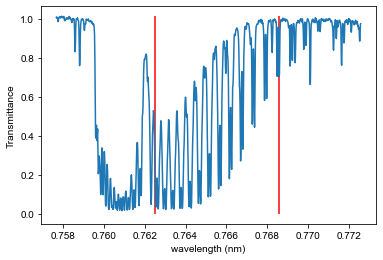

In [380]:
start, end = 290, 700
plt.plot(wl[0], T[0,0])
plt.vlines(wl[0, [start, end]], 0, np.max(T[0,0]), 'r')
plt.xlabel('wavelength (nm)')
plt.ylabel('Transmittance')
#plt.xlim(0.762, 0.765)

Text(0, 0.5, 'Absorbance')

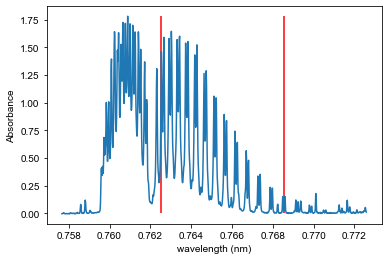

In [379]:
start, end = 290, 700
plt.plot(wl[0], A[0,0])
plt.vlines(wl[0, [start, end]], 0, np.max(A[0,0]), 'r')
plt.xlabel('wavelength (nm)')
plt.ylabel('Absorbance')
#plt.xlim(0.762, 0.765)

In [58]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
from scipy.special import wofz

def Voigt(x, x0, y0, a, sigma, gamma):
    #sigma = alpha / np.sqrt(2 * np.log(2))

    return y0 + a * np.real(wofz((x - x0 + 1j*gamma)/sigma/np.sqrt(2))) / sigma /np.sqrt(2*np.pi)




In [59]:
x = wl[0, start:end], 
y = tau[0,0,start:end]

sigma = 2.4
gamma = 2.4
popt, pcov = curve_fit(Voigt, x, y,)# p0=[8, np.max(y), -(np.max(y)-np.min(y)), sigma, gamma])

TypeError: Improper input: N=5 must not exceed M=1

In [345]:
start, end = 285, 700
local_min_bottom = []
local_min_up = []
local_min = []
local_max = []
search_interval = 5
for i in range(search_interval, len(A[0,0,start:end])-search_interval):
    if np.argmin(A[0,0,start+i-search_interval:start+i+search_interval+1]) == search_interval:
        local_min.append(start+i)
    if np.argmax(A[0,0,start+i-search_interval:start+i+search_interval+1]) == search_interval:
        local_max.append(start+i)


local_min_up = []
local_min_bottom = []
local_min_up.append(local_min[0])
for j in range(1, len(local_min)-1):
    if np.argmax(A[0,0,local_min[j-1:j+2]])==1:
        local_min_up.append(local_min[j])
    else:
        local_min_bottom.append(local_min[j])

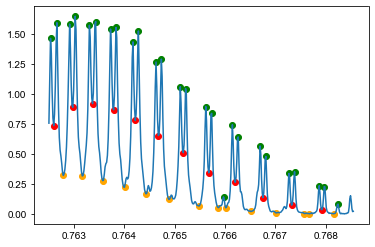

In [381]:

plt.plot(wl[0, start:end], A[0,0,start:end])
plt.scatter(wl[0, local_min_up], A[0,0,local_min_up], color='r')
plt.scatter(wl[0, local_min_bottom], A[0,0,local_min_bottom], color='orange')
plt.scatter(wl[0, local_max], A[0,0,local_max], color='g')
#plt.xlim(0.762, 0.765)

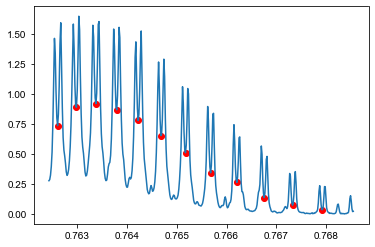

In [347]:

plt.plot(wl[0, start:end], A[0,0,start:end])
plt.scatter(wl[0, local_min_up], A[0,0,local_min_up], color='r')
#plt.scatter(wl[0, local_min_bottom], A[0,0,local_min_bottom], color='g')
#plt.xlim(0.762, 0.765)

In [197]:
def func2(x, a, b, c, d):
    return a * (np.exp(-(x-d)**2/(2*b**2))) +c

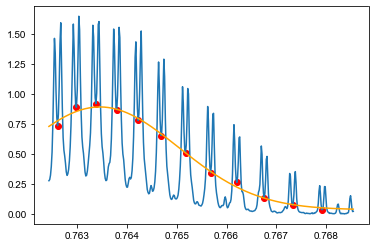

In [348]:
popt, pcov = curve_fit(func2, wl[0, local_min_up], A[0,0,local_min_up],
                      bounds=((1e-3, 1e-5, 0.0, 0.762), (2.0, 1, 2, 0.764)))
plt.plot(wl[0, start:end], A[0,0,start:end])
plt.scatter(wl[0, local_min_up], A[0,0,local_min_up], color='r')
plt.plot(wl[0, start:end], func2(wl[0, start:end], *popt), color='orange')
plt.show()

In [214]:
popt

array([0.3295846 , 0.0016705 , 0.00141695, 0.76252963])

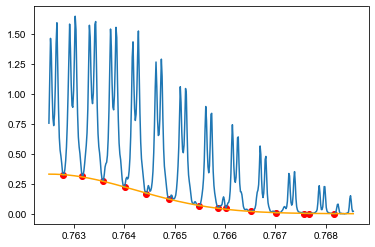

In [382]:

popt, pcov = curve_fit(func2, wl[0, local_min_bottom], A[0,0,local_min_bottom],
                      bounds=((1e-3, 1e-5, 0.0, 0.762), (2.0, 1, 2, 0.764)))
plt.plot(wl[0, start:end], A[0,0,start:end])
plt.scatter(wl[0, local_min_bottom], A[0,0,local_min_bottom], color='r')
plt.plot(wl[0, start:end], func2(wl[0, start:end], *popt), color='orange')
#plt.plot(wl[0, start:end], func2(wl[0, start:end], popt[0]+0.1, *popt[1:]), color='g')
plt.show()

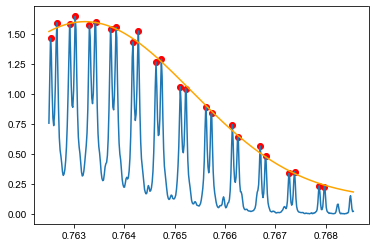

array([1.48193583, 0.00212321, 0.11869579, 0.76322244])

In [383]:
max_index = np.argsort(A[0,0,local_max])[2:]
popt, pcov = curve_fit(func2, wl[0, np.array(local_max)[max_index]], A[0,0,np.array(local_max)[max_index]],
                          p0=[0.6, 0.00366845,  0.61514387, 0.763],
                      bounds=((1e-3, 1e-5, 0.0, 0.762), (2.0, 1, 2, 0.764)))
plt.plot(wl[0, start:end], A[0,0,start:end])

plt.scatter(wl[0, np.array(local_max)[max_index]], A[0,0,np.array(local_max)[max_index]], color='r')
plt.plot(wl[0, start:end], func2(wl[0, start:end], *popt), color='orange')
plt.show()
popt

In [324]:
local_min_bottom_array = np.zeros((A.shape[0], A.shape[1], 4))
local_min_up_array = np.zeros((A.shape[0], A.shape[1], 4))
local_max_array = np.zeros((A.shape[0], A.shape[1], 4))
local_min_bottom_array[...] = np.nan
local_min_up_array[...] = np.nan
local_max_array[...] = np.nan

start, end = 285, 700+1
search_interval = 5

for i in range(A.shape[0]):
    for fp in range(8):
        if qf_array[i, fp, 0] >= 0:

            local_min = []
            local_max = []
            
            for ii in range(search_interval, len(A[i, fp,start:end])-search_interval):
                if np.argmin(A[i, fp,start+ii-search_interval:start+ii+search_interval+1]) == search_interval:
                    local_min.append(start+ii)
                if np.argmax(A[i, fp,start+ii-search_interval:start+ii+search_interval+1]) == search_interval:
                    local_max.append(start+ii)
            local_min_up = []
            local_min_bottom = []
            local_min_up.append(local_min[0])
            for j in range(1, len(local_min)-1):
                if np.argmax(A[i, fp,local_min[j-1:j+2]])==1:
                    local_min_up.append(local_min[j])
                else:
                    local_min_bottom.append(local_min[j])
            popt_up, pcov = curve_fit(func2, wl[fp, local_min_up], A[i, fp,local_min_up],
                                      bounds=((1e-3, 1e-5, 0.0, 0.762), (2.0, 1, 2, 0.764)))
            popt_bottom, pcov = curve_fit(func2, wl[fp, local_min_bottom], A[i, fp,local_min_bottom],
                                       bounds=((1e-3, 1e-5, 0.0, 0.762), (2.0, 1, 2, 0.764)))
            max_index = np.argsort(A[i, fp,local_max])[2:]

            popt_max, pcov = curve_fit(func2, wl[fp, np.array(local_max)[max_index]], A[i, fp,np.array(local_max)[max_index]],
                                       bounds=((1e-3, 1e-5, 0.0, 0.762), (3.0, 1, 2, 0.764)))

            local_min_up_array[i, fp, :] = popt_up[:]
            local_min_bottom_array[i, fp, :] = popt_bottom[:]
            local_max_array[i, fp, :] = popt_max[:]
            


In [325]:
(~np.isnan(local_min_up_array.flatten())).sum()

8944

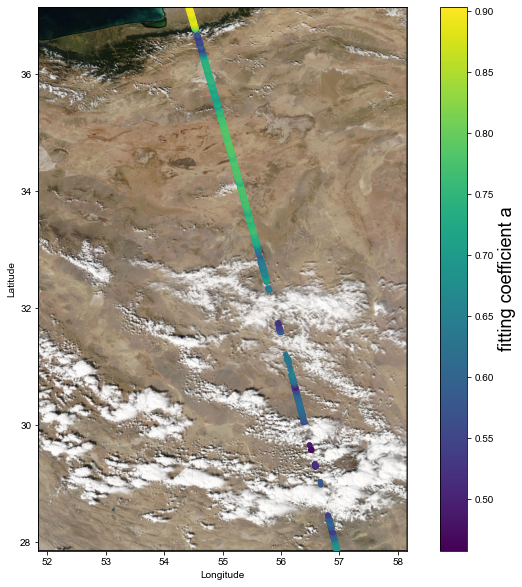

In [386]:
f,frame=plt.subplots(figsize=(12, 10))
img = png[0]
wesn= png[1]
img = mpimg.imread(img)
frame.imshow(img,extent=wesn)
lon_dom = [lon_w, lon_e]
lat_dom = [lat_s, lat_n]
frame.set_xlim(np.min(lon_dom), np.max(lon_dom))
frame.set_ylim(np.min(lat_dom), np.max(lat_dom))
qf_01 = np.logical_or(qf_array[:, :, 0].flatten()==0, qf_array[:, :, 0].flatten()==1)
c = frame.scatter(qf_lon.flatten()[qf_01], qf_lat.flatten()[qf_01], s=20,
              marker='o', c=local_min_up_array[:,:,0].flatten()[qf_01])

cbar = f.colorbar(c)
cbar.set_label('fitting coefficient a', fontsize=18)
#frame.scatter(lon_cld[cld_list>0], lat_cld[cld_list>0], s=5, color='r')
#for i in range(len(boundary_list)):
#    boundary = boundary_list[i]
#    plot_rec(np.mean(boundary[0][:2]), np.mean(boundary[0][2:]), 
#             0.5, lat_interval, 
#             frame, 'r')
#plt.legend(fontsize=16, facecolor='white')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

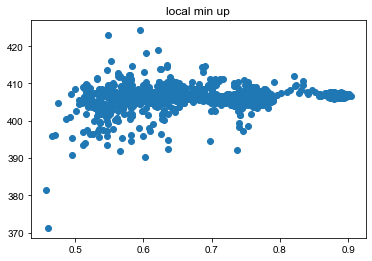

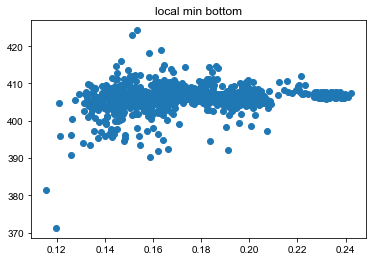

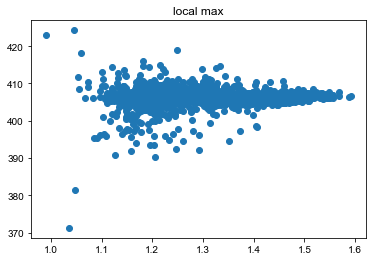

In [333]:
para = 0
plt.scatter(local_min_up_array[:,:,para], xco2_array[:,:])
plt.title('local min up')
plt.show()
plt.scatter(local_min_bottom_array[:,:,para], xco2_array[:,:])
plt.title('local min bottom')
plt.show()
plt.scatter(local_max_array[:,:,para], xco2_array[:,:])
plt.title('local max')
plt.show()

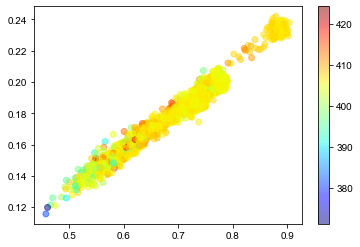

In [363]:
para = 0
plt.scatter(local_min_up_array[:,:,para], local_min_bottom_array[:,:,para], c=xco2_array[:,:], alpha=0.5,cmap='jet')
plt.colorbar()

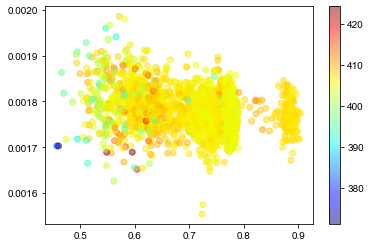

In [375]:
para = 0
plt.scatter(local_min_up_array[:,:,0], local_min_bottom_array[:,:,1], c=xco2_array[:,:], alpha=0.5,cmap='jet')
plt.colorbar()

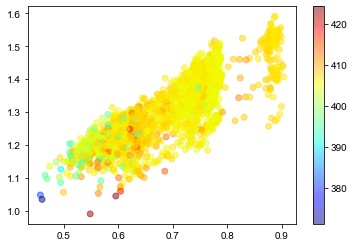

In [356]:
plt.scatter(local_min_up_array[:,:,para], local_max_array[:,:,para], c=xco2_array[:,:], alpha=0.5,cmap='jet')
plt.colorbar()

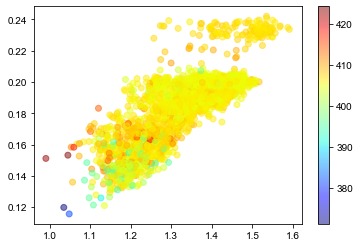

In [358]:
plt.scatter(local_max_array[:,:,para], local_min_bottom_array[:,:,para], c=xco2_array[:,:], alpha=0.5,cmap='jet')
plt.colorbar()

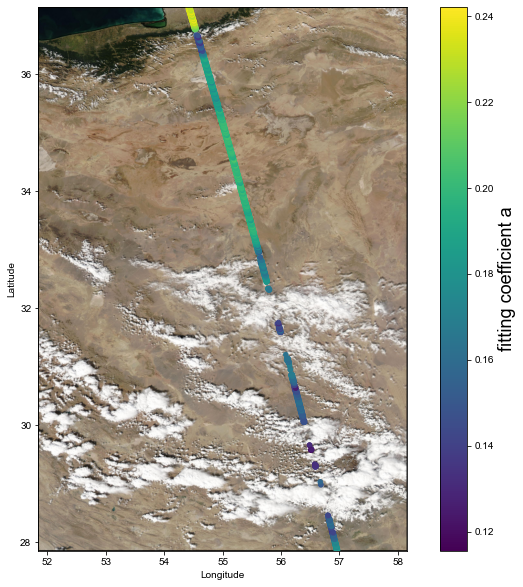

In [387]:
f,frame=plt.subplots(figsize=(12, 10))
img = png[0]
wesn= png[1]
img = mpimg.imread(img)
frame.imshow(img,extent=wesn)
lon_dom = [lon_w, lon_e]
lat_dom = [lat_s, lat_n]
frame.set_xlim(np.min(lon_dom), np.max(lon_dom))
frame.set_ylim(np.min(lat_dom), np.max(lat_dom))
qf_01 = np.logical_or(qf_array[:, :, 0].flatten()==0, qf_array[:, :, 0].flatten()==1)
c = frame.scatter(qf_lon.flatten()[qf_01], qf_lat.flatten()[qf_01], s=20,
              marker='o', c=local_min_bottom_array[:,:,0].flatten()[qf_01])

cbar = f.colorbar(c)
cbar.set_label('fitting coefficient a', fontsize=18)
#frame.scatter(lon_cld[cld_list>0], lat_cld[cld_list>0], s=5, color='r')
#for i in range(len(boundary_list)):
#    boundary = boundary_list[i]
#    plot_rec(np.mean(boundary[0][:2]), np.mean(boundary[0][2:]), 
#             0.5, lat_interval, 
#             frame, 'r')
#plt.legend(fontsize=16, facecolor='white')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

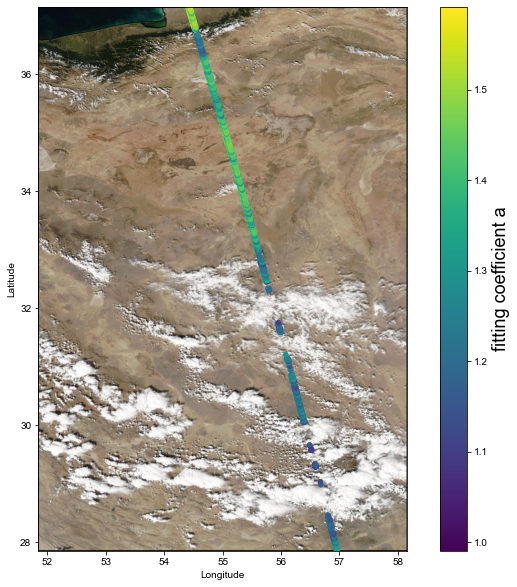

In [388]:
f,frame=plt.subplots(figsize=(12, 10))
img = png[0]
wesn= png[1]
img = mpimg.imread(img)
frame.imshow(img,extent=wesn)
lon_dom = [lon_w, lon_e]
lat_dom = [lat_s, lat_n]
frame.set_xlim(np.min(lon_dom), np.max(lon_dom))
frame.set_ylim(np.min(lat_dom), np.max(lat_dom))
qf_01 = np.logical_or(qf_array[:, :, 0].flatten()==0, qf_array[:, :, 0].flatten()==1)
c = frame.scatter(qf_lon.flatten()[qf_01], qf_lat.flatten()[qf_01], s=20,
              marker='o', c=local_max_array[:,:,0].flatten()[qf_01])

cbar = f.colorbar(c)
cbar.set_label('fitting coefficient a', fontsize=18)
#frame.scatter(lon_cld[cld_list>0], lat_cld[cld_list>0], s=5, color='r')
#for i in range(len(boundary_list)):
#    boundary = boundary_list[i]
#    plot_rec(np.mean(boundary[0][:2]), np.mean(boundary[0][2:]), 
#             0.5, lat_interval, 
#             frame, 'r')
#plt.legend(fontsize=16, facecolor='white')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()